In [8]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [9]:
N_ENSEMBLE=50

In [10]:
def get_mse(chunk_means, djangoh_vals):
    bias = []
    for i in chunk_means:
        bias.append(np.square(np.subtract(i, djangoh_vals)))

    # print(f"bias: {np.mean(np.square(bias))/np.mean(chunk_means)}")
    # print(f"bias: {bias}")
    bias_squared = np.mean(bias,axis=0)
    # print(f"np.mean(bias,axis=0): {np.mean(bias,axis=0)}")
    mse = bias_squared/np.mean(djangoh_vals)
    # print(f"mse:{mse}")
    return mse


In [11]:
def get_stdv_from_files(files, truth=None):

    data = [np.load(file) for file in files]
    
    # Initialize a dictionary to hold lists of y-values for each x-value index
    y_values_per_x_index = {}
    ratio_values_per_x_index = {}
    x_values = np.load(files[0])[0]  # Load the x-values from the first file


    for single_file_data in data:
        for i, y in enumerate(single_file_data[1]):  # single_file_data[1] are the y-values
            if i not in y_values_per_x_index:
                y_values_per_x_index[i] = []
            y_values_per_x_index[i].append(y)        
    
        for i, r in enumerate(single_file_data[2]):  # single_file_data[1] are the y-values
            if i not in ratio_values_per_x_index:
                ratio_values_per_x_index[i] = []
            ratio_values_per_x_index[i].append(r)
    # print(len(y_values_per_x_index))        
    # print(f"y_values_per_x_index: {y_values_per_x_index}")

    mean = [np.mean(y_values) for y_values in y_values_per_x_index.values()]
    # print(f"mean: {mean}")
    if truth is None: #Standard Deviation, using Means
        for y_values in y_values_per_x_index.values():
            # print(y_values)
            std_devs = [np.std(y_values)/np.mean(y_values) for y_values in y_values_per_x_index.values()]
        # print(std_devs)
            ratio_std_devs = [np.std(y_values) for y_values in ratio_values_per_x_index.values()]
        

    else: #MSE, from truth. Usually Djanhog in the closure studies
        std_devs = [np.mean([(y - truth[1][i]) ** 2 for y in y_values])/np.mean(truth[1][i]) for i, y_values in y_values_per_x_index.items()]
        ratio_std_devs = [np.mean([(y - truth[2][i]) ** 2 for y in y_values]) for i, y_values in ratio_values_per_x_index.items()]
        
    # print(f" HARRYYY   std_devs: {std_devs}")
    return x_values, std_devs, ratio_std_devs, mean

In [12]:
def truncated_mean_axis0(data, percentage=10):
    """
    Calculate truncated mean along axis 0
    
    Parameters:
    -----------
    data : 2D numpy array
        Input data array with shape (n_samples, n_features)
    percentage : float
        Percentage to trim from both ends (default: 10%)
        
    Returns:
    --------
    1D numpy array
        Truncated mean for each feature
    """
    n_samples = data.shape[0]
    n_features = data.shape[1]
    
    # Calculate number of elements to remove from each end
    k = int(n_samples * percentage / 100 / 2)
    
    # Initialize result array
    result = np.zeros(n_features)
    
    # For each feature (column), calculate truncated mean
    for i in range(n_features):
        column = np.sort(data[:, i])
        # Remove k smallest and k largest values and compute mean
        result[i] = np.mean(column[k:n_samples-k])
    
    return result

In [13]:
def plot_feature(feature, xlabel, title, unit):
    ## first get baseline rapgap and djangoh
    fig = plt.figure(figsize=(20, 5))  # Increased height to accommodate new plots
    outer_gs = gridspec.GridSpec(1, 3, figure=fig, hspace=0.3, wspace=0.2) # 2 rows, 3 cols, with padding

    alpha = 0.8
    label_size = 16
    E_Max = 5

    rapgap = np.load(f'../plots/Rapgap_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens0_plot_vals.npy')
    djangoh = np.load(f'../plots/Djangoh_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens0_plot_vals.npy')

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer_gs[0, 0], height_ratios=[3, 1], hspace=0.05
    )
    ax1_top = fig.add_subplot(inner_gs[0])
    ax1_bottom = fig.add_subplot(inner_gs[1], sharex=ax1_top)
    r_scatter = ax1_top.scatter(
        rapgap[0], rapgap[1],
        marker='_', label='Rapgap',
        alpha=alpha, s=100, color='k'
    )
    # print(f"rapgap[1]: {rapgap[1]}")
    d_scatter = ax1_top.fill_between(
        djangoh[0], djangoh[1],
        step='mid', color='gray',
        alpha=0.3, label='Djangoh'
    )

    ax1_top.set_title(f'{title}', fontsize=20)
    ax1_top.set_ylabel('Normalized Counts', fontsize=label_size)
    ax1_top.tick_params(axis='both', which='major', labelsize=12)
    # Remove x-axis tick marks and labels on the top subplot
    ax1_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax1_top.grid(True)

    # --- Bottom Subplot: Ratio Plot ---
    ax1_bottom.set_ylabel(r'Ratio', fontsize=label_size)
    ax1_bottom.set_xlabel(f'{xlabel} {unit}', fontsize=label_size)
    ax1_bottom.set_ylim(0.5, 1.5)
    ax1_bottom.tick_params(axis='both', which='major', labelsize=12)
    ax1_bottom.grid(True)

    # Group the ensemble models into chunks of 10
    chunk_size = 5
    num_chunks = (N_ENSEMBLE + chunk_size - 1) // chunk_size  # Ceiling division to handle non-divisible cases
    
    # Initialize arrays to store the chunk statistics
    chunk_means = []
    chunk_medians = []
    chunk_truncmeans = []
    chunk_file_paths = []  # Store file paths for each chunk for std_dev calculations
    
    # For storing x values
    x_values = None
    
    # Process each chunk
    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min(start_idx + chunk_size, N_ENSEMBLE)
        
        # Arrays to collect data and file paths for this chunk
        chunk_y_vals = []
        chunk_files = []
        
        # Process each ensemble in this chunk
        for n in range(start_idx, end_idx):
            step_file = f'../plots/Rapgap_unfolded{n}_H1_March_ModelLists_5lrscale_patience10_parallel_closure_{feature}_ens{n}_plot_vals.npy'
            # print(f"chunk #: {chunk_idx}, step_file: {step_file}")
            if not os.path.exists(step_file):
                print(f"Skipping missing file: {step_file}")
                continue
                
            # Add file path to the chunk files
            chunk_files.append(step_file)
            
            step_data = np.load(step_file)
            
            # Store x values once, assuming they're the same for all files
            if x_values is None:
                x_values = step_data[0]
                
            chunk_y_vals.append(step_data[1])
            # print(f"step_data[1]: {step_data[1]}")
            # print(f" {step_data[1]}")
        
        # Skip empty chunks
        if not chunk_y_vals or len(chunk_files) < 2:  # Need at least 2 files for std dev calculation
            print(f"Skipping empty or single-file chunk {chunk_idx+1}")
            continue
            
        # Convert to numpy array for calculations
        chunk_y_vals_arr = np.vstack(chunk_y_vals)
        
        # Calculate statistics for this chunk
        chunk_mean = np.mean(chunk_y_vals_arr, axis=0)
        chunk_median = np.median(chunk_y_vals_arr, axis=0)
        chunk_truncmean = truncated_mean_axis0(chunk_y_vals_arr, percentage=10)
        
        # Store chunk statistics
        chunk_means.append(chunk_mean)
        chunk_medians.append(chunk_median)
        chunk_truncmeans.append(chunk_truncmean)
        chunk_file_paths.append(chunk_files)  # Store file paths for std_dev calculations

    chunk_std_devs = []
    chunk_ratio_std_devs = []  # To store ratio std devs
    chunk_std_dev_ratios = []  # To store ratios between std devs
    
    # Arrays to store per-x-value statistics for the final plots
    all_x_values = None
    all_std_devs_per_x = []
    all_mse_per_x = []
    
    # Arrays to store std_devs for each statistical method
    all_mean_std_devs_per_x = []
    all_median_std_devs_per_x = []
    all_truncmean_std_devs_per_x = []
    
    # Arrays to store MSE for each statistical method
    all_mean_mse_per_x = []
    all_median_mse_per_x = []
    all_truncmean_mse_per_x = []
    
    for chunk_idx, chunk_files in enumerate(chunk_file_paths):
        if len(chunk_files) >= 2:  # Need at least 2 files for std dev calculation
            # Use the provided get_stdv_from_files function
            x_vals, std_devs, ratio_std_devs, means = get_stdv_from_files(chunk_files, truth=None)
            
            # Store all x values (only need to do this once)
            if all_x_values is None:
                all_x_values = x_vals
            
            # Store std_devs for later plotting
            all_std_devs_per_x.append(std_devs)
            
            # Calculate MSE compared to djangoh truth
            _, mse_values, _, _ = get_stdv_from_files(chunk_files, truth=djangoh)
            # print(f"mse_values:{mse_values}")
            all_mse_per_x.append(mse_values)
            
            # Store average std_dev and ratio_std_dev for this chunk
            avg_std_dev = np.mean(std_devs)
            avg_ratio_std_dev = np.mean(ratio_std_devs)
            
            chunk_std_devs.append(avg_std_dev)
            chunk_ratio_std_devs.append(avg_ratio_std_dev)
            
            # Calculate ratio of std_dev to ratio_std_dev if needed
            if avg_ratio_std_dev > 0:
                std_dev_ratio = avg_std_dev / avg_ratio_std_dev
                chunk_std_dev_ratios.append(std_dev_ratio)
            

    
    # Calculate the average of all chunk statistics
    if chunk_means:
        final_mean = np.mean(chunk_means, axis=0)
        final_median = np.mean(chunk_medians, axis=0)
        final_truncmean = np.mean(chunk_truncmeans, axis=0)


        
        # Calculate average of standard deviations
        final_std_dev = np.mean(chunk_std_devs) if chunk_std_devs else 0
        final_std_dev_ratio = np.mean(chunk_std_dev_ratios) if chunk_std_dev_ratios else 0


        stdv_mean = np.std(chunk_means, axis=0)
        stdv_median = np.std(chunk_medians, axis=0)
        stdv_truncmean = np.std(chunk_truncmeans, axis=0)

        djangoh_vals = djangoh[1]

        ax1_top.scatter(x_values, final_mean, marker='o', label="Parallel(Mean)", color='blue', facecolors='none')    
        ax1_top.scatter(x_values, final_median, marker='*', label="Parallel(Median)", color='green', facecolors='none')    
        ax1_top.scatter(x_values, final_truncmean, marker='v', label="Parallel(Truncated Mean)", color='red', facecolors='none')    

        bias = []
        for i in chunk_means:
            bias.append(np.square(np.subtract(i, djangoh_vals)))

        # print(f"bias: {np.mean(np.square(bias))/np.mean(chunk_means)}")
        # print(f"bias: {bias}")
        bias_squared = np.mean(bias,axis=0)
        # print(f"np.mean(bias,axis=0): {np.mean(bias,axis=0)}")
        mse = bias_squared/np.mean(chunk_means, axis=0)
        # print(f"mse:{mse}")

        mse_mean = get_mse(chunk_means,djangoh_vals)
        mse_median = get_mse(chunk_medians, djangoh_vals)
        mse_truncmean = get_mse(chunk_truncmeans, djangoh_vals)


            
            
        ax1_top.set_ylim(0, 1.5*np.max(final_truncmean))
        
        # Plot ratios
        ax1_bottom.scatter(
            rapgap[0], rapgap[1]/djangoh[1],
            marker='_', alpha=alpha, color='k'
        )
        
        ax1_bottom.scatter(
            x_values, final_mean/djangoh[1],
            marker='o', alpha=alpha, color='blue', facecolors='none'
        )
        
        ax1_bottom.scatter(
            x_values, final_median/djangoh[1],
            marker='*', alpha=alpha, color='green', facecolors='none'
        )
        
        ax1_bottom.scatter(
            x_values, final_truncmean/djangoh[1],
            marker='v', alpha=alpha, color='red', facecolors='none'
        )
    else:
        print("No valid chunks found")
    
    ax1_bottom.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7)  # Reference line at ratio=1
    
    ax4 = fig.add_subplot(outer_gs[1])
    ax4.plot(x_values, (stdv_mean/final_mean), 'o-', color='blue', linewidth=2, label='Parallel(Mean)', markerfacecolor='none')
    ax4.plot(all_x_values, (stdv_median/final_median), '*-', color='green', linewidth=2, label='Parallel(Median)', markerfacecolor='none')
    ax4.plot(all_x_values, (stdv_truncmean/final_truncmean), 'v-', color='red', linewidth=2, label='Parallel(Truncated Mean)', markerfacecolor='none')

    ax4.set_xlabel(f'{xlabel} {unit}', fontsize=label_size)
    ax4.set_ylabel('Standard Deviation / Mean', fontsize=label_size)
    ax4.set_title('Standard Deviation', fontsize=20)
    ax4.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax4.grid(True, alpha=0.3)
 
               
    y_vals_avg, ratio_avg = 0, 0
    y_vals_step = []
    files = glob.glob(f'/pscratch/sd/f/fernando/H1Unfold/plots/Rapgap_unfoldedAvg_H1_Feb_Seed1234_emaGetSetWeighs_archL61_closure_job[0-9]_fromscratch_{feature}_ensAvg_plot_vals.npy')[:10]

    for n, file in enumerate(files):
        step_data = np.load(file)

        # Correct: use length of step_data[0] for shifting calculation
        step_shift = max(step_data[0]) / len(step_data[0]) / 10 / (n + 1)
        y_vals_avg += step_data[1]
        y_vals_step.append(step_data[1])
        ratio_avg += step_data[2]
    # print(f"y_vals_step:{y_vals_step}")
    step_stdv = np.std(y_vals_step, axis=0)/np.mean(y_vals_step, axis=0)
    y_vals_avg =   y_vals_avg/len(files)  
    # print(f"y_vals_avg/len(files): {y_vals_avg/len(files)}")    
    ax1_top.scatter(x_values, y_vals_avg, marker='o', label="Step", color='black', facecolors='none')   
    ax4.plot(x_values, step_stdv, 'o-', color='black', linewidth=2, label='Step', markerfacecolor='none') 

    ax1_top.legend(fontsize=12, loc='upper right', ncol=2, columnspacing=1.5, handletextpad=0.5)
    ax4.legend()

    mse_step = get_mse(y_vals_step, djangoh_vals)

    ax5 = fig.add_subplot(outer_gs[2])
    ax5.plot(x_values, mse_mean, 'o-', color='blue', linewidth=2, label='Parallel(Mean)', markerfacecolor='none')
    ax5.plot(x_values, mse_median, '*-', color='green', linewidth=2, label='Parallel(Median)', markerfacecolor='none')
    ax5.plot(x_values, mse_truncmean, 'v-', color='red', linewidth=2, label='Parallel(Truncated Mean)', markerfacecolor='none')
    ax5.plot(x_values, mse_step, 'o-', color='black', linewidth=2, label='Step', markerfacecolor='none')

    ax5.set_xlabel(f'{xlabel} {unit}', fontsize=label_size)
    ax5.set_ylabel('MSE', fontsize=label_size)
    ax5.set_title('MSE', fontsize=20)
    ax5.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax5.grid(True, alpha=0.3)

    ax5.legend()
    plt.tight_layout()
    # plt.savefig(f'../plots/extended_{feature}_plot.png', dpi=300, bbox_inches='tight')
    # plt.close()

/tmp/ipykernel_2153103/1042426800.py:273: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2153103/3489428661.py:29: RuntimeWarning: invalid value encountered in scalar divide
  std_devs = [np.std(y_values)/np.mean(y_values) for y_values in y_values_per_x_index.values()]
/tmp/ipykernel_2153103/1042426800.py:187: RuntimeWarning: divide by zero encountered in divide
  mse = bias_squared/np.mean(chunk_means, axis=0)
/tmp/ipykernel_2153103/1042426800.py:225: RuntimeWarning: invalid value encountered in divide
  ax4.plot(x_values, (stdv_mean/final_mean), 'o-', color='blue', linewidth=2, label='Parallel(Mean)', markerfacecolor='none')
/tmp/ipykernel_2153103/1042426800.py:226: RuntimeWarning: invalid value encountered in divide
  ax4.plot(all_x_values, (stdv_median/final_median), '*-', color='green', linewidth=2, label='Parallel(Median)', markerfacecolor='none')
/tmp/ipykernel_2153103/104242680

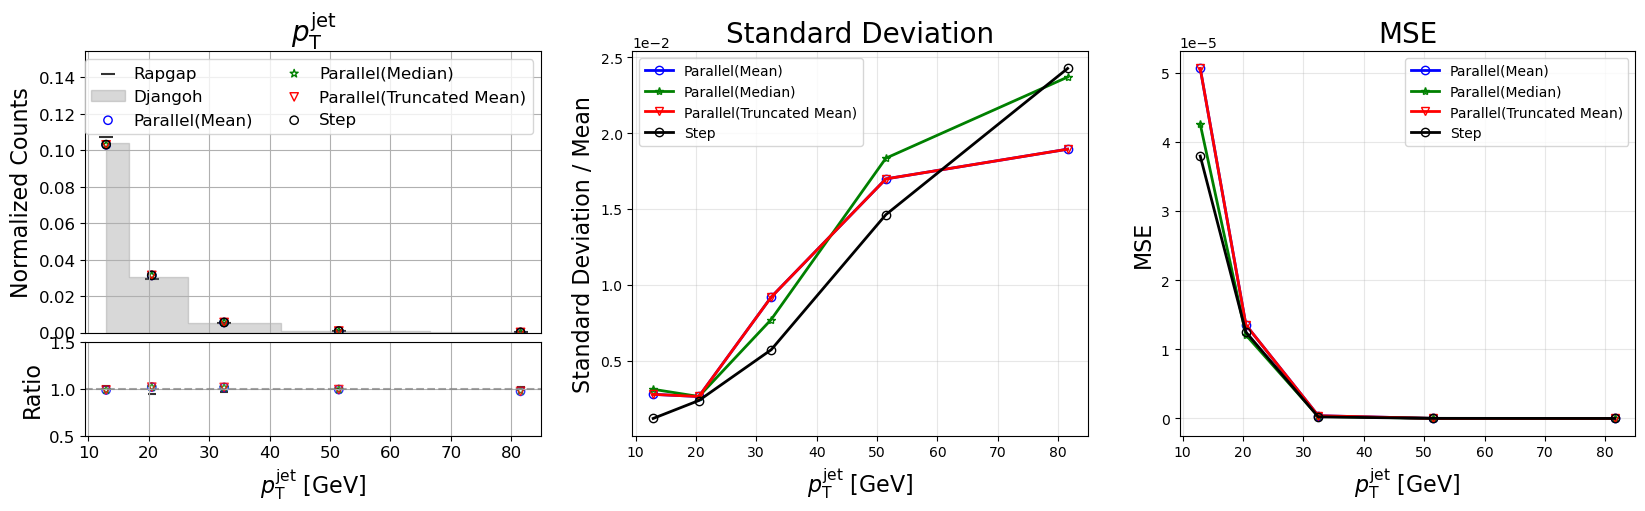

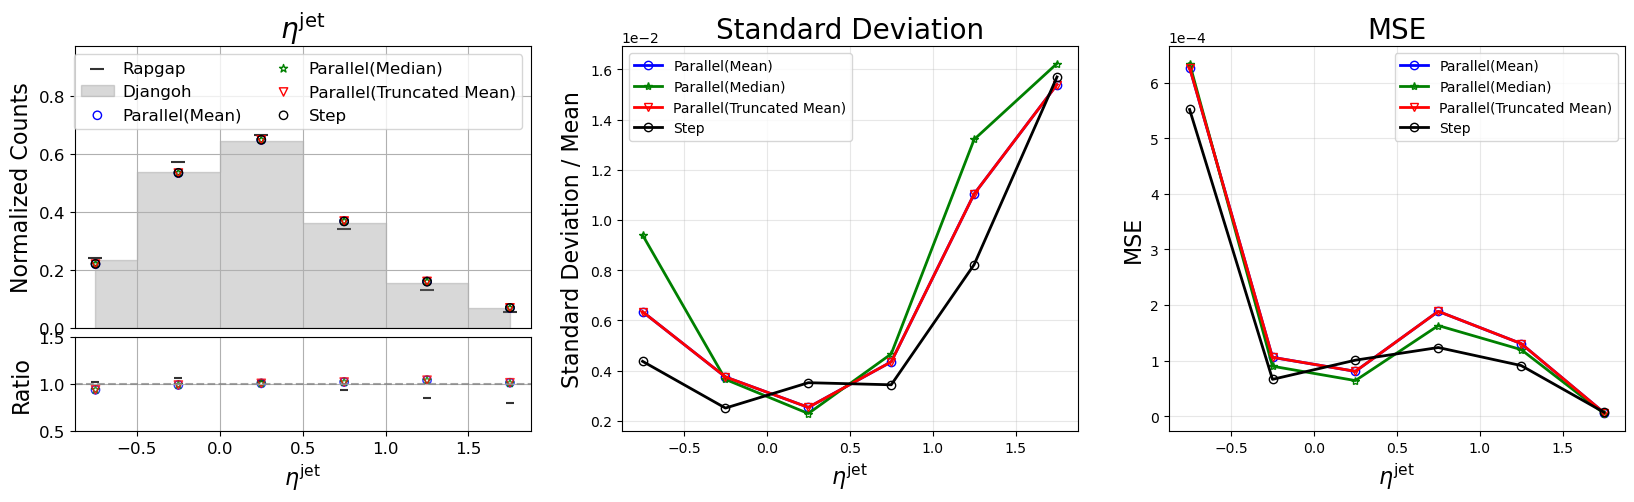

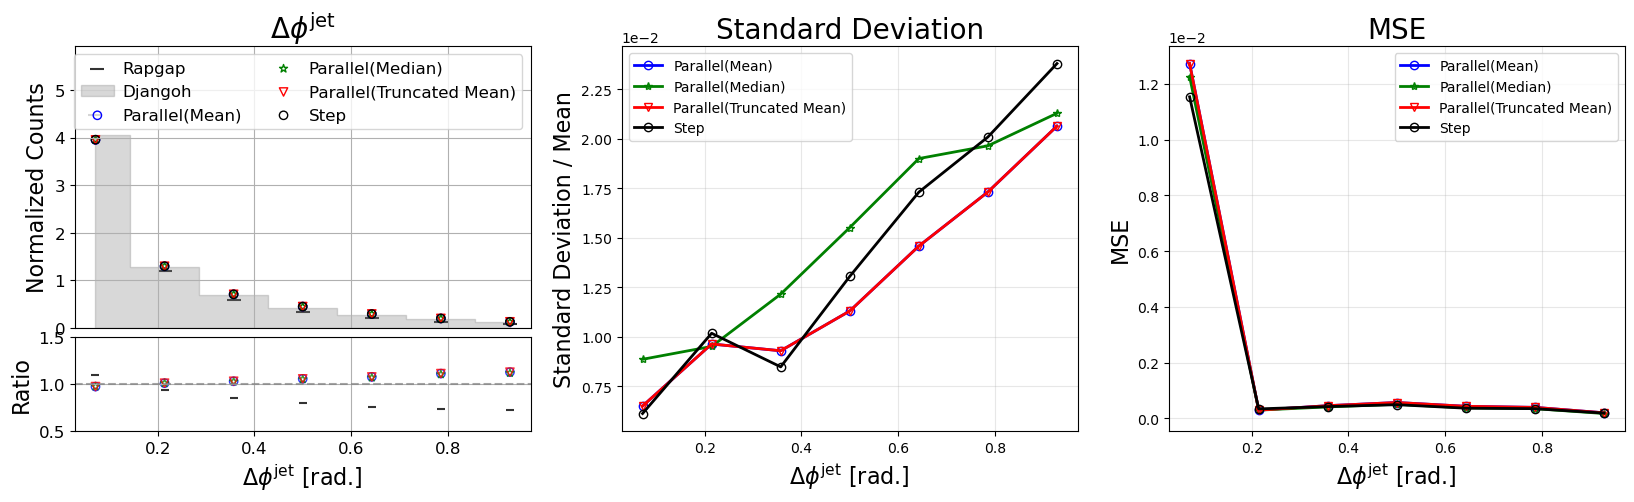

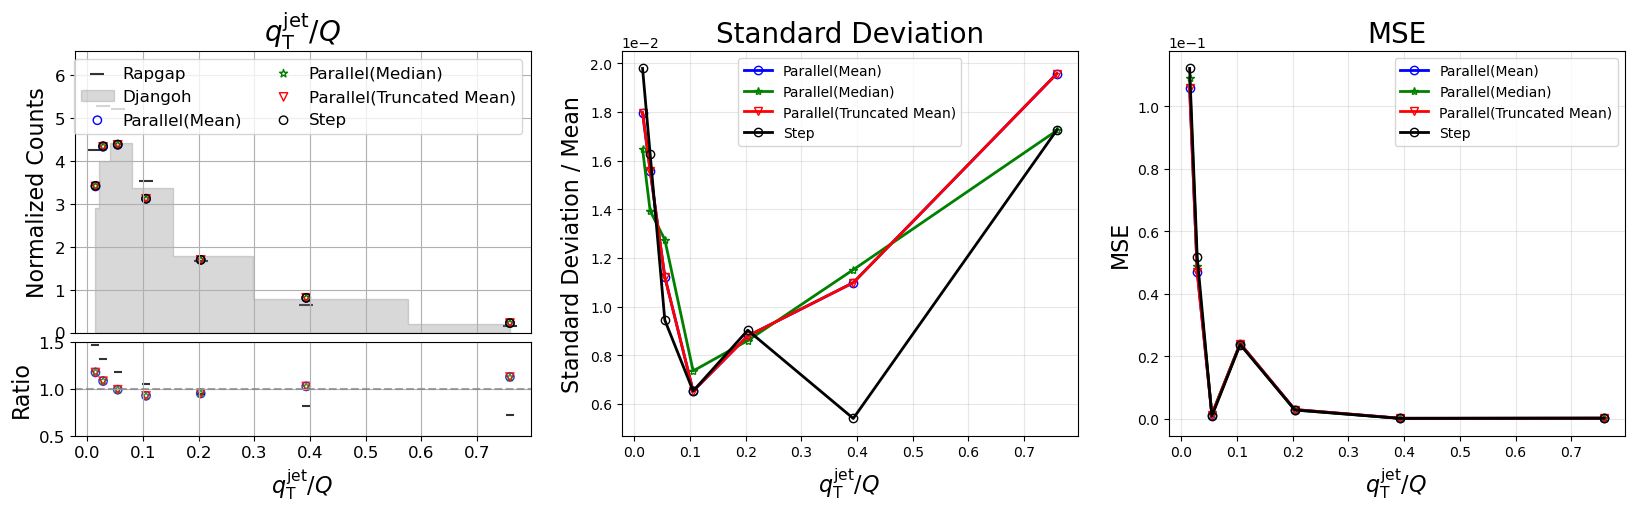

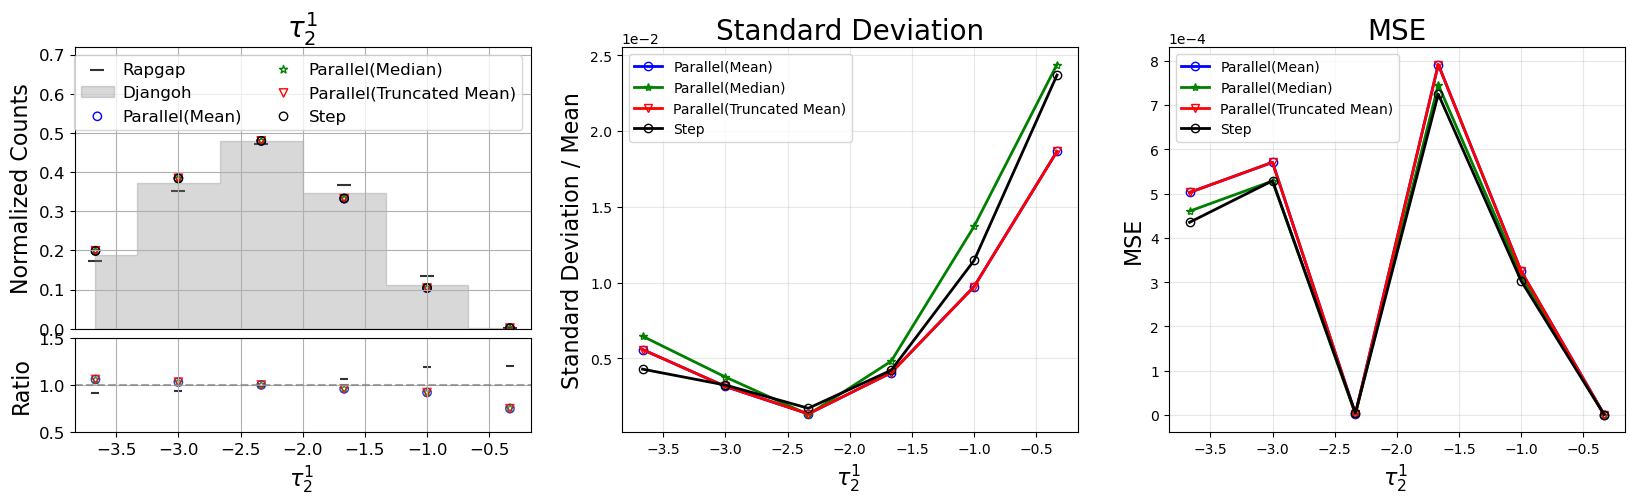

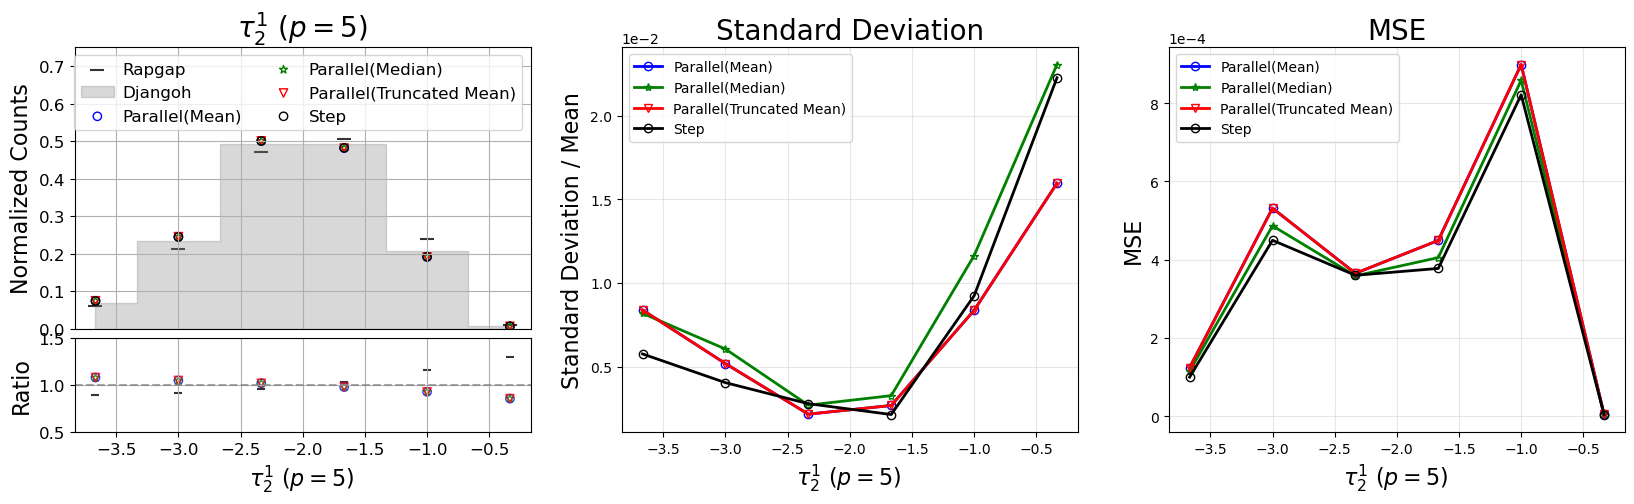

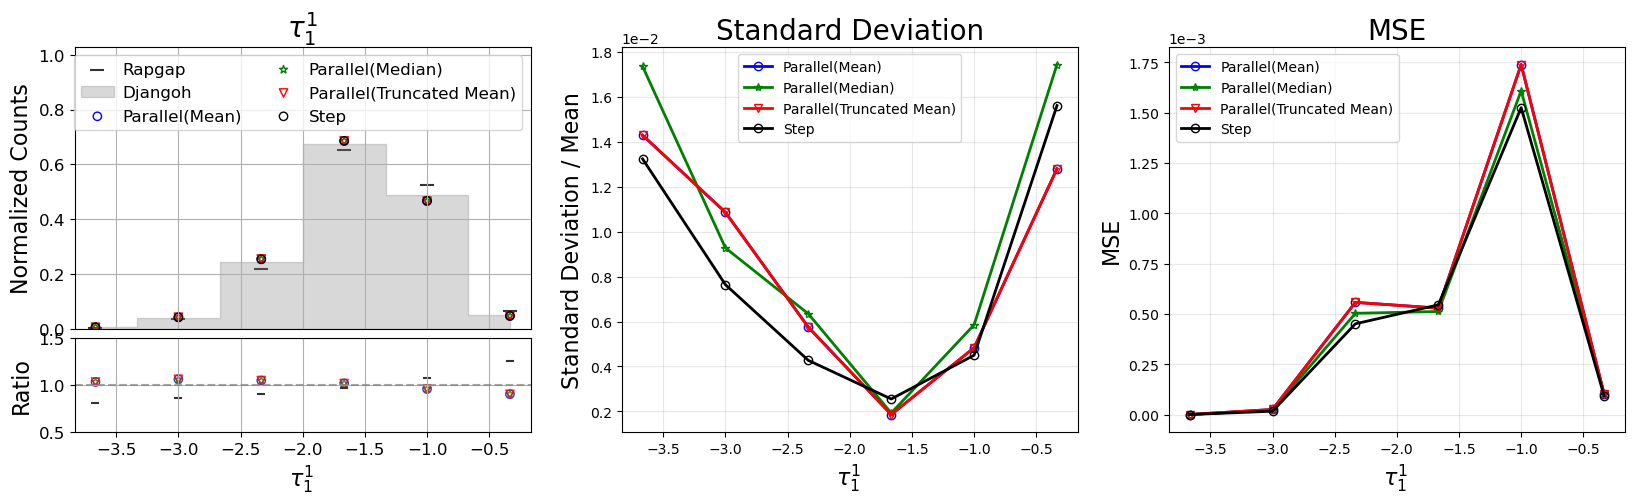

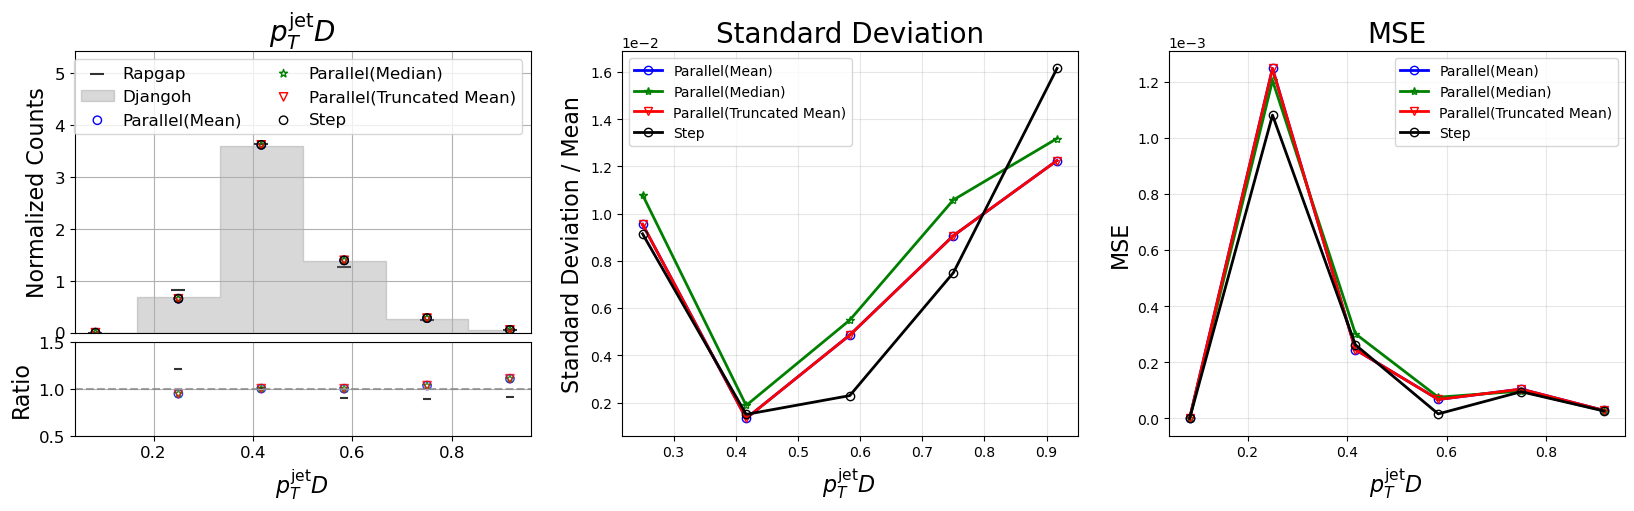

In [14]:
jet_features = ['jet_pT', 'jet_eta', 'jet_phi', 'jet_qT', 'jet_tau12', 'jet_tau11p5', 'jet_tau11', 'jet_ptD']
jet_labels = [r'$p_\mathrm{T}^\mathrm{jet}$',r'$\eta^\mathrm{jet}$',
              r'$\Delta\phi^\mathrm{jet}$',r'$q_\mathrm{T}^\mathrm{jet}/Q$', 
              r'$\tau^1_2$', r'$\tau^1_2\ (p=5)$', r'$\tau^1_1$', '$p^\mathrm{jet}_{T}D$']
units = ['[GeV]','','[rad.]','','','','','']
for jet_feature, jet_label, unit in zip(jet_features, jet_labels, units):
    plot_feature(jet_feature, jet_label, jet_label, unit)

/tmp/ipykernel_2153103/1042426800.py:273: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/tmp/ipykernel_2153103/3489428661.py:29: RuntimeWarning: invalid value encountered in scalar divide
  std_devs = [np.std(y_values)/np.mean(y_values) for y_values in y_values_per_x_index.values()]
/tmp/ipykernel_2153103/3489428661.py:35: RuntimeWarning: invalid value encountered in scalar divide
  std_devs = [np.mean([(y - truth[1][i]) ** 2 for y in y_values])/np.mean(truth[1][i]) for i, y_values in y_values_per_x_index.items()]
/tmp/ipykernel_2153103/1042426800.py:187: RuntimeWarning: invalid value encountered in divide
  mse = bias_squared/np.mean(chunk_means, axis=0)
/tmp/ipykernel_2153103/1042426800.py:201: RuntimeWarning: invalid value encountered in divide
  rapgap[0], rapgap[1]/djangoh[1],
/tmp/ipykernel_2153103/1042426800.py:206: RuntimeWarning: invalid value encountered in divide
  x_values, final_mean/djangoh[1],
/tmp/ipykernel_2153103/1042426800.py:211: RuntimeWarning: invalid value encountered in divide
  x_values, final_median/djangoh[1],
/tmp/ipykernel_2153103/1042426800.p

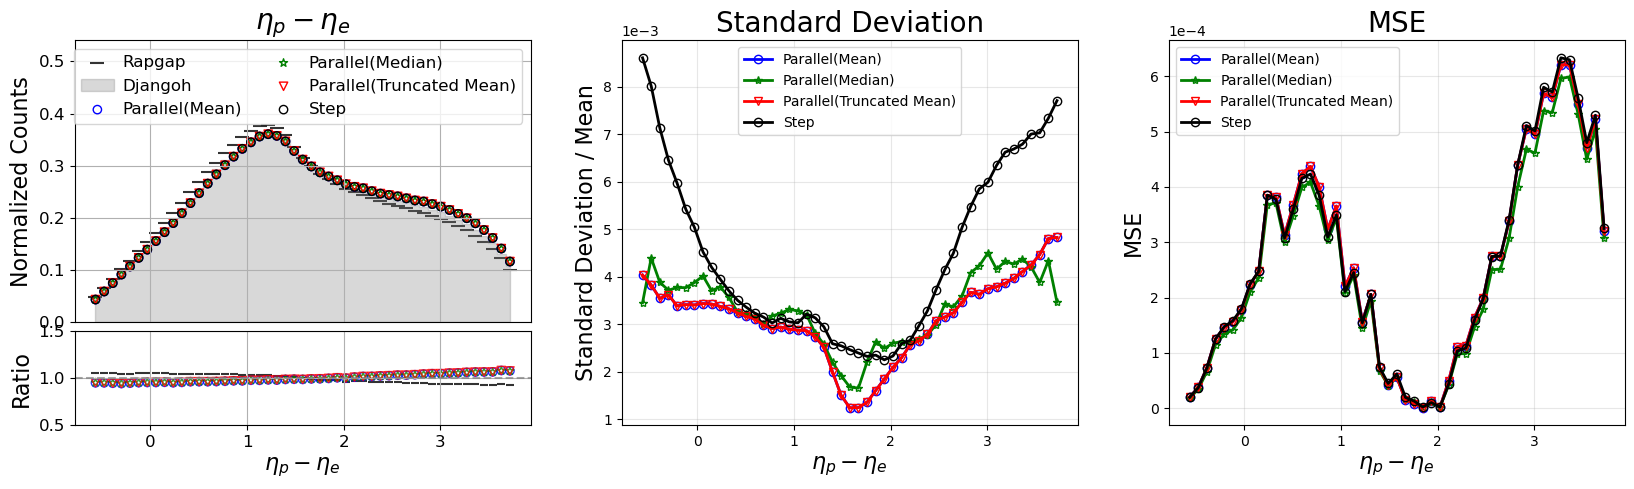

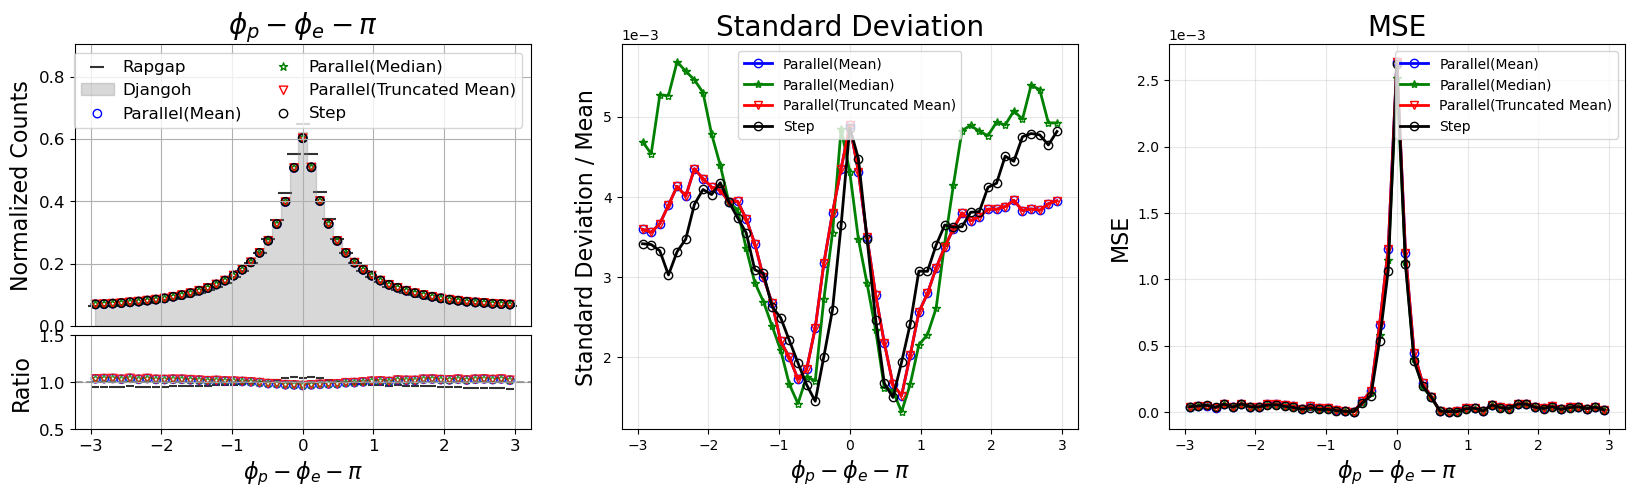

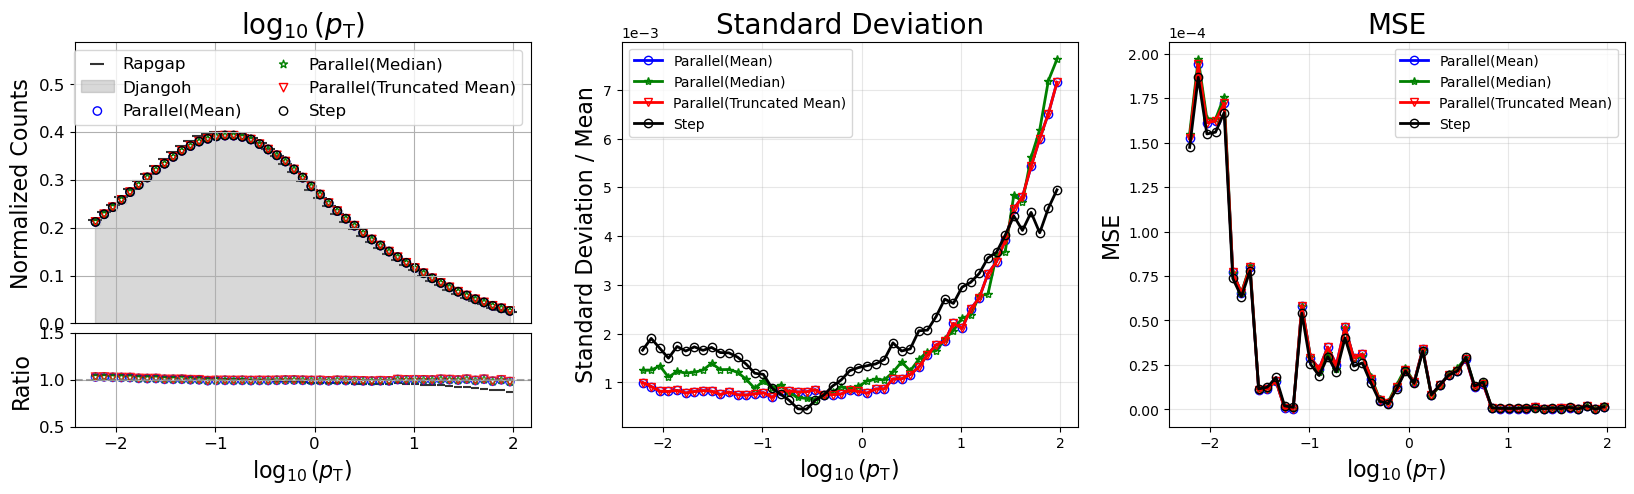

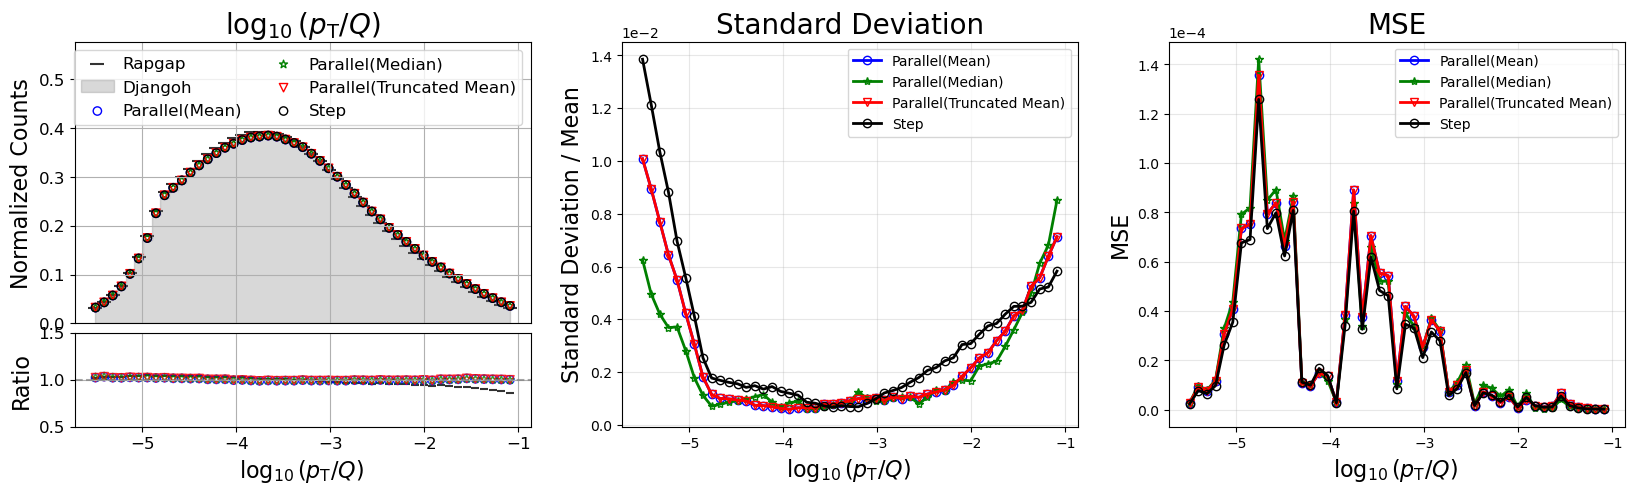

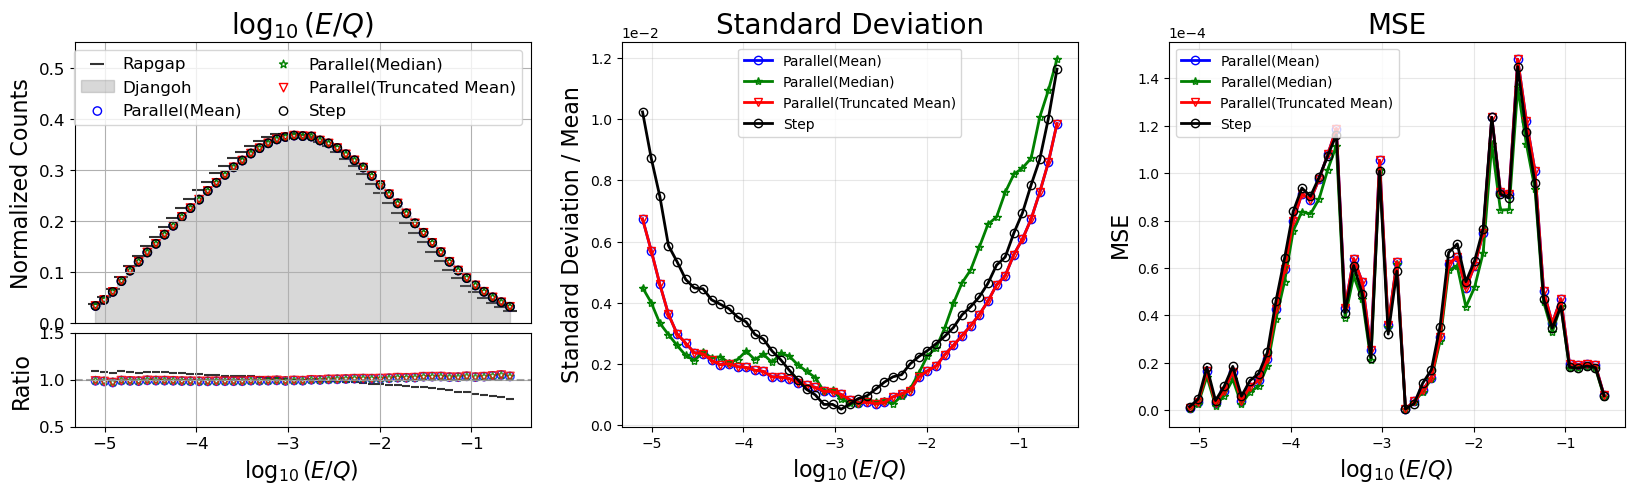

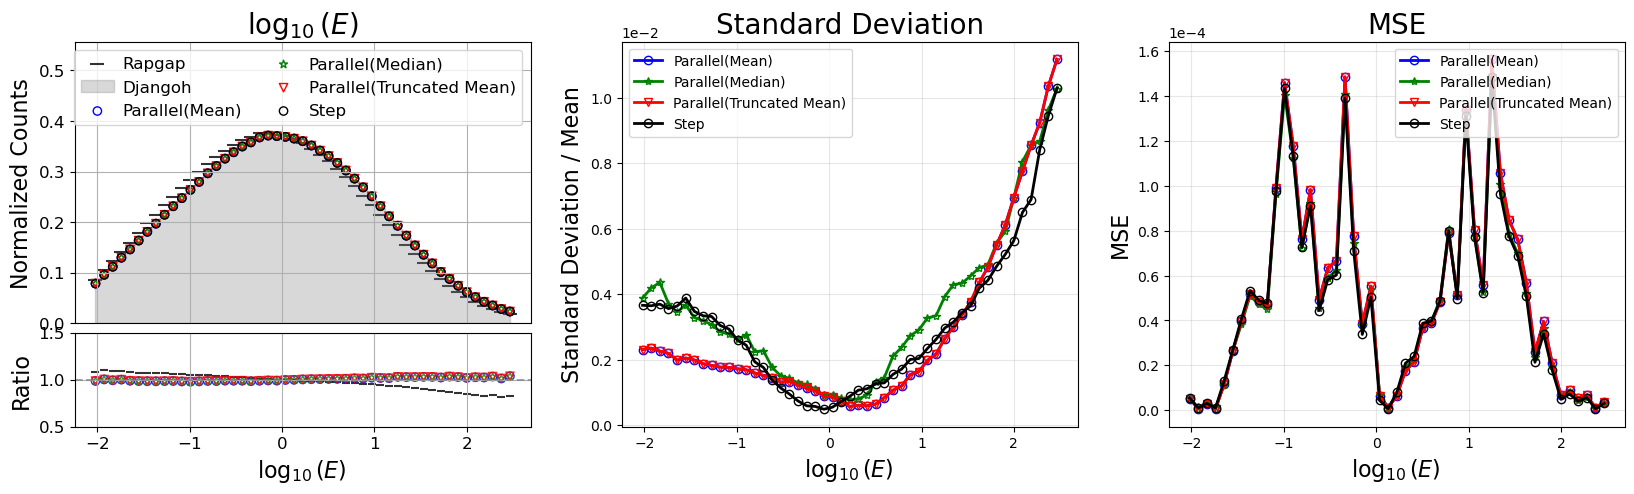

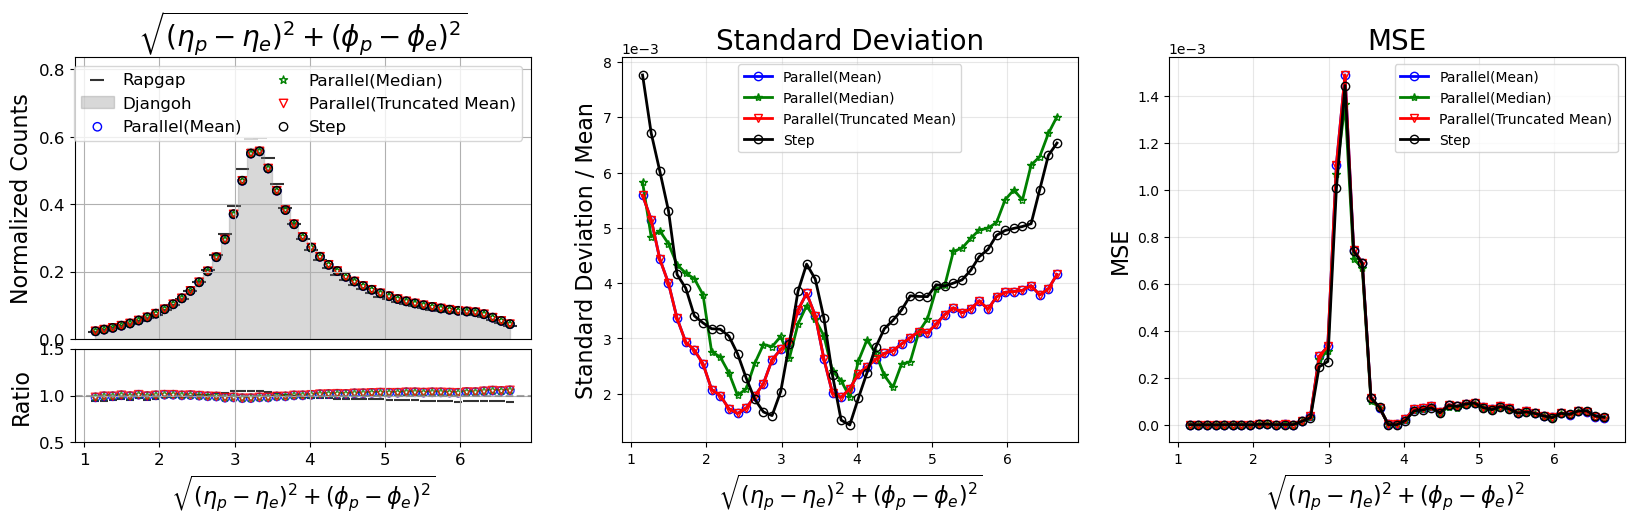

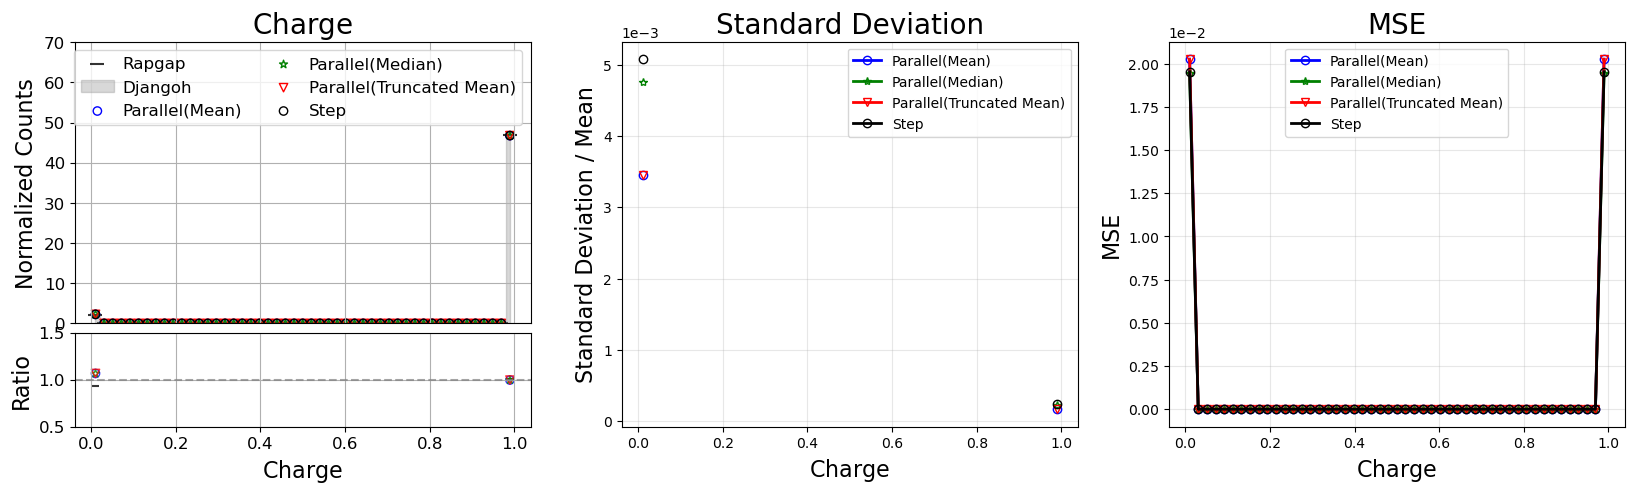

In [15]:
particle_labels = [
    '$\eta_p - \eta_e$',
    '$\phi_p-\phi_e-\pi$',
    '$\log_{10}(p_\mathrm{T})$',
    '$\log_{10}(p_\mathrm{T}/Q)$',
    '$\log_{10}(E/Q)$',
    '$\log_{10}(E)$',
    '$\sqrt{(\eta_p-\eta_e)^2+(\phi_p-\phi_e)^2}$',
    '$\mathrm{Charge}$']

particle_features = [f'particle{p}' for p in range(len(particle_labels))]

for particle_feature, particle_label in zip(particle_features, particle_labels):
    plot_feature( particle_feature, particle_label, particle_label, unit)
    print()


/tmp/ipykernel_2153103/1042426800.py:273: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


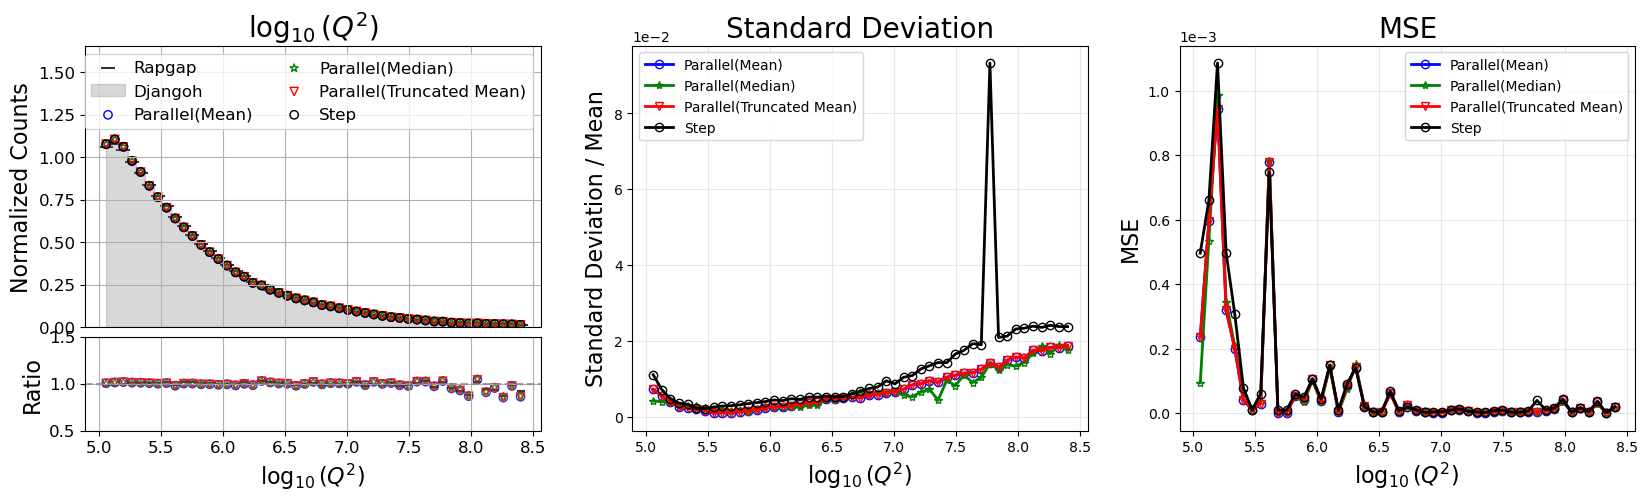

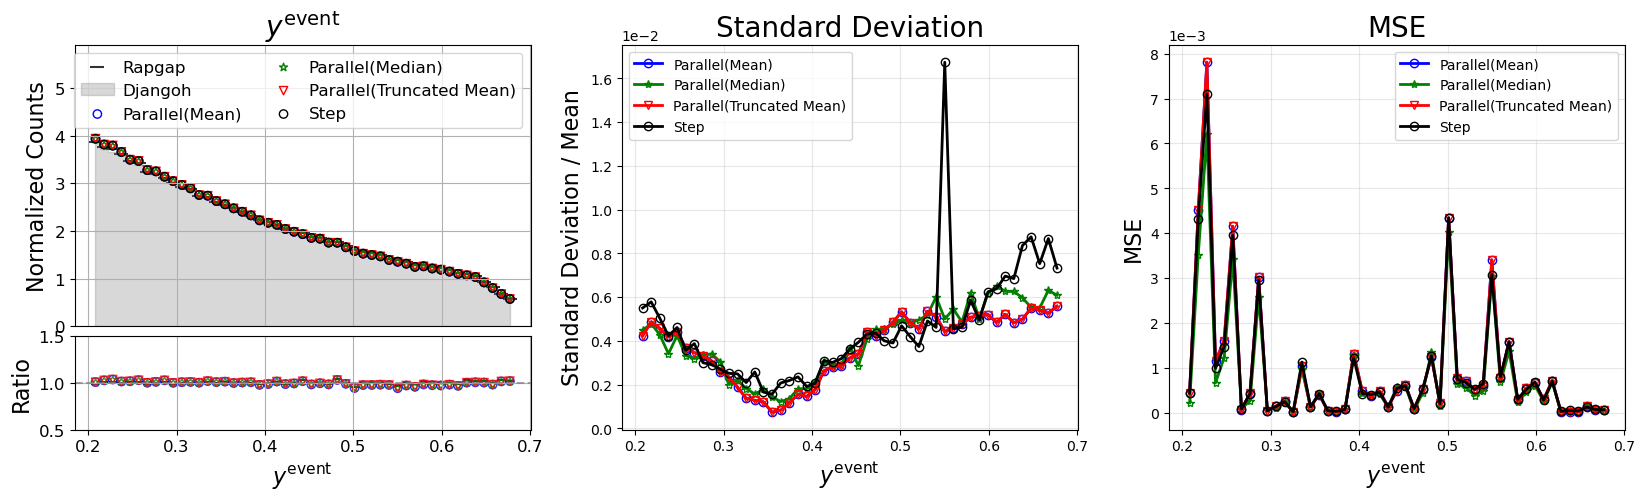

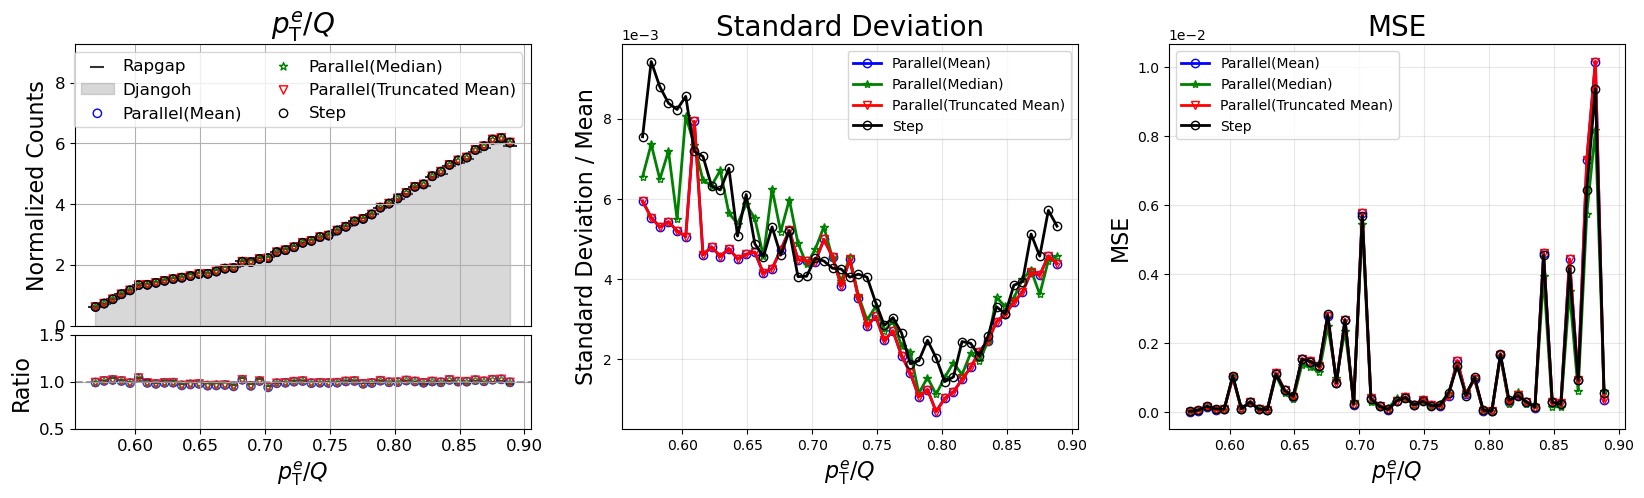

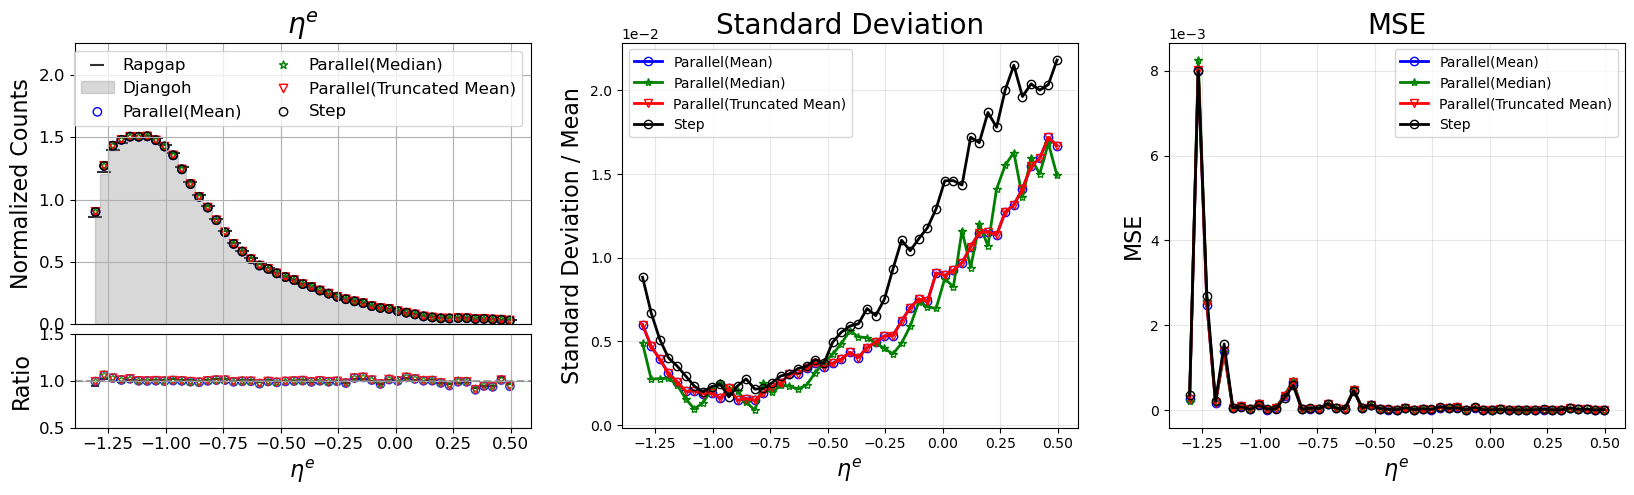

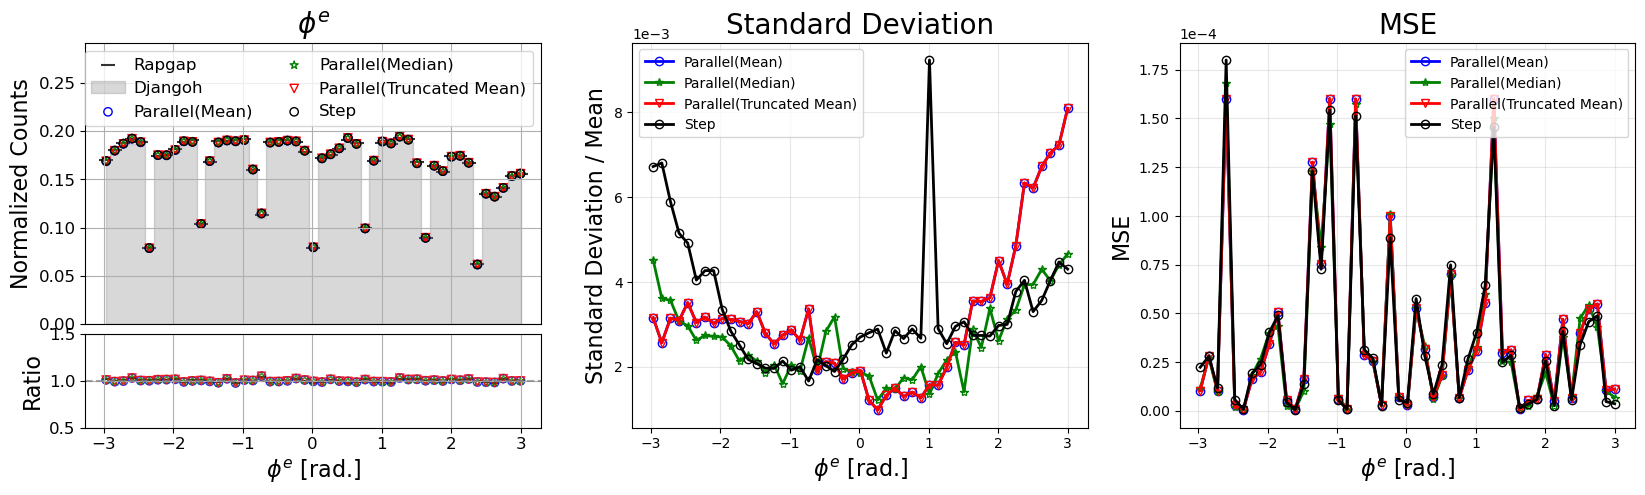

In [16]:
event_labels = [r'$\log_{10}(Q^2)$',r'$y^\mathrm{event}$',r'$p_\mathrm{T}^e/Q$',r'$\eta^e$',r'$\phi^e$']
event_features = [f"event{e}" for e in range(len(event_labels))]
units = ["", "", "", "", "[rad.]"]
avg_Npts = 4
for event_feature, event_label, unit in zip(event_features, event_labels, units):
    plot_feature( event_feature, event_label, event_label, unit)
    print()